# Enregistrement et chevauchement d'images

Ce chapitre explore comment comparer et aligner plusieurs images, une tâche essentielle pour évaluer la qualité de segmentation et fusionner des données provenant de sources multiples.

---

## Concepts clés

- **Génération de données synthétiques** : création de formes géométriques
- **Métriques de chevauchement** : Dice, Dice pondéré, corrélation
- **Distance euclidienne** : localisation de barycentres
- **Sélection par seuil** : filtrer les correspondances

In [1]:
# Importation des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
from utils import generate_square

---

## Génération de données synthétiques

Créer des images de test avec des formes géométriques distribuées selon différentes lois statistiques.

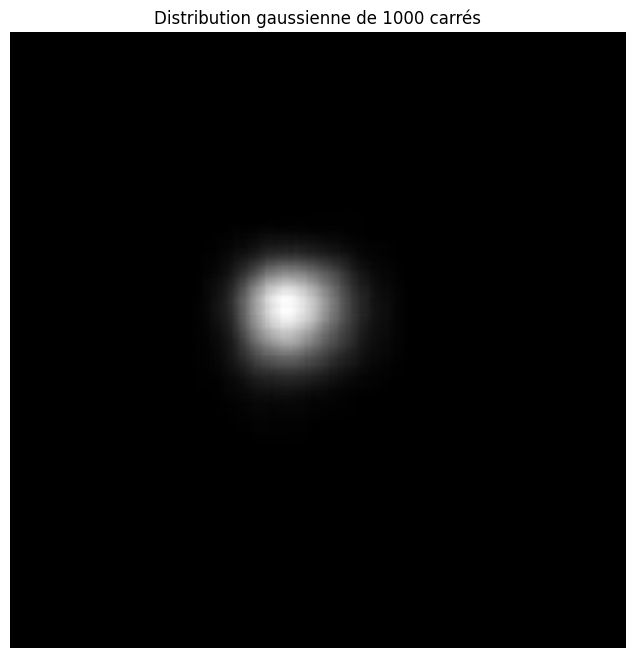

Dimensions : (500, 500)
Valeur min : 0.0, max : 510.0


In [2]:
# Initialiser 1000 carrés avec des positions et tailles suivant une distribution gaussienne
np.random.seed(1234)
shape = (500, 500)
arr_smooth = np.zeros(shape)

# Générer les positions et tailles avec distribution gaussienne
# Centré en (200, 200) avec écart-type 20
center = np.random.normal(200, 20, size=2000).reshape((1000, 2))
# Taille moyenne 50 avec écart-type 20
size = np.random.normal(50, 20, size=2000).reshape((1000, 2))

# Dessiner chaque carré et les accumuler
for i in range(1000):
    arr_smooth += generate_square(shape, center[i], size[i])

# Afficher le résultat
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(arr_smooth, cmap='gray')
ax.set_title("Distribution gaussienne de 1000 carrés")
ax.axis('off')
plt.show()

print(f"Dimensions : {arr_smooth.shape}")
print(f"Valeur min : {np.min(arr_smooth)}, max : {np.max(arr_smooth)}")

---

## Distribution uniforme

Créer une deuxième image avec les mêmes formes mais distribuées uniformément dans l'espace.

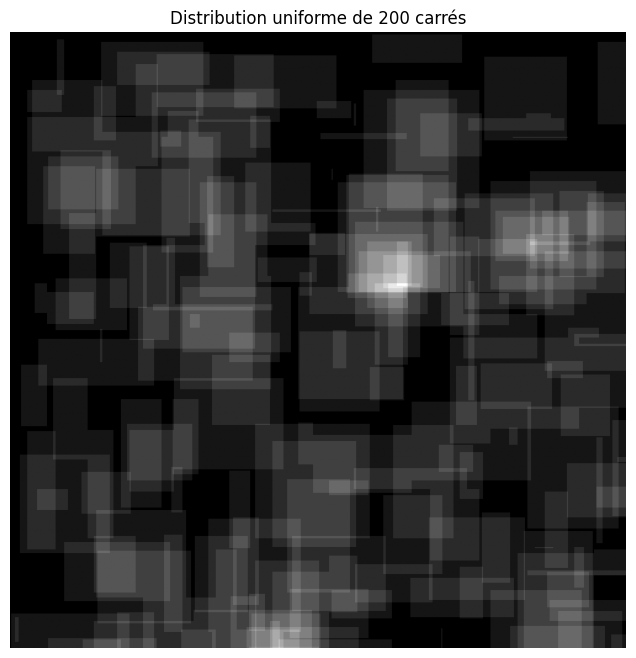

In [3]:
# Initialiser 200 carrés avec positions et tailles suivant une distribution uniforme
np.random.seed(1066)
arr = np.zeros(shape)

# Générer positions uniformément distribuées dans toute l'image
center = np.random.random(400).reshape((200, 2)) * arr.shape[0]
# Générer tailles uniformément distribuées (max 1/5 de la taille de l'image)
size = np.random.random(400).reshape((200, 2)) * arr.shape[0] // 5

# Dessiner chaque carré
for i in range(200):
    arr += generate_square(shape, center[i], size[i])

# Afficher le résultat
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(arr, cmap='gray')
ax.set_title("Distribution uniforme de 200 carrés")
ax.axis('off')
plt.show()

---

## Métriques de chevauchement

Comparer les images en utilisant différentes métriques :
- **Dice** : similitude binaire
- **Dice pondéré** : similitude pondérée par intensité
- **Corrélation** : mesure linéaire de dépendance

In [4]:
# Fonctions de calcul de chevauchement
def compute_dice_voxel(density_1, density_2):
    """Calculer Dice et Dice pondéré entre deux images."""
    # Trouver les voxels où les deux images sont non-zéro
    overlap_idx = np.nonzero(density_1 * density_2)
    
    # Dice = 2 * |intersection| / (|A| + |B|)
    numerator = 2 * len(overlap_idx[0])
    denominator = np.count_nonzero(density_1) + np.count_nonzero(density_2)
    
    if denominator > 0:
        dice = numerator / float(denominator)
    else:
        dice = np.nan
    
    # Dice pondéré = (somme(A) + somme(B)) / (somme_total(A) + somme_total(B))
    overlap_1 = density_1[overlap_idx]
    overlap_2 = density_2[overlap_idx]
    w_dice = np.sum(overlap_1) + np.sum(overlap_2)
    denominator = np.sum(density_1) + np.sum(density_2)
    
    if denominator > 0:
        w_dice /= denominator
    else:
        w_dice = np.nan
    
    return dice, w_dice


def compute_correlation(density_1, density_2):
    """Calculer la corrélation entre deux images."""
    # Obtenir les indices où au moins une image est non-zéro
    indices = np.where(density_1 + density_2 > 0)
    
    # Cas spéciaux
    if np.array_equal(density_1, density_2):
        correlation = 1.0
    elif (np.sum(density_1) > 0 and np.sum(density_2) > 0) and \
         np.count_nonzero(density_1 * density_2) > 0:
        # Calculer la corrélation seulement dans les régions pertinentes
        correlation = np.corrcoef(density_1[indices], density_2[indices])[0, 1]
    else:
        correlation = 0.0
    
    return max(0, correlation)

---

## Sélection par métriques de chevauchement

Parcourir les 200 carrés unifor mes et ne garder que ceux qui se chevauchent bien avec la distribution gaussienne.

Chevauchement pour chaque carré :
Index | Dice  | W-Dice | Corr  | Somme | Sélectionné
-------------------------------------------------------
   0  | 0.079 | 0.009  | 0.000 | 0.089 | NON
   1  | 0.032 | 0.007  | 0.000 | 0.039 | NON
   2  | 0.000 | 0.000  | 0.000 | 0.000 | NON
   3  | 0.000 | 0.000  | 0.000 | 0.000 | NON
   4  | 0.123 | 0.030  | 0.000 | 0.153 | OUI
   5  | 0.000 | 0.000  | 0.000 | 0.000 | NON
   6  | 0.000 | 0.000  | 0.000 | 0.000 | NON
   7  | 0.000 | 0.000  | 0.000 | 0.000 | NON
   8  | 0.000 | 0.000  | 0.000 | 0.000 | NON
   9  | 0.181 | 0.032  | 0.000 | 0.213 | OUI
  14  | 0.102 | 0.010  | 0.000 | 0.112 | OUI
  21  | 0.329 | 0.240  | 0.042 | 0.611 | OUI
  24  | 0.190 | 0.065  | 0.000 | 0.256 | OUI
  49  | 0.012 | 0.026  | 0.171 | 0.209 | OUI
  54  | 0.253 | 0.322  | 0.326 | 0.901 | OUI
  61  | 0.174 | 0.031  | 0.000 | 0.205 | OUI
  66  | 0.154 | 0.016  | 0.000 | 0.171 | OUI
  73  | 0.060 | 0.069  | 0.145 | 0.275 | OUI
  92  | 0.059 | 0.085  | 0.211 | 0.355 | OUI
  

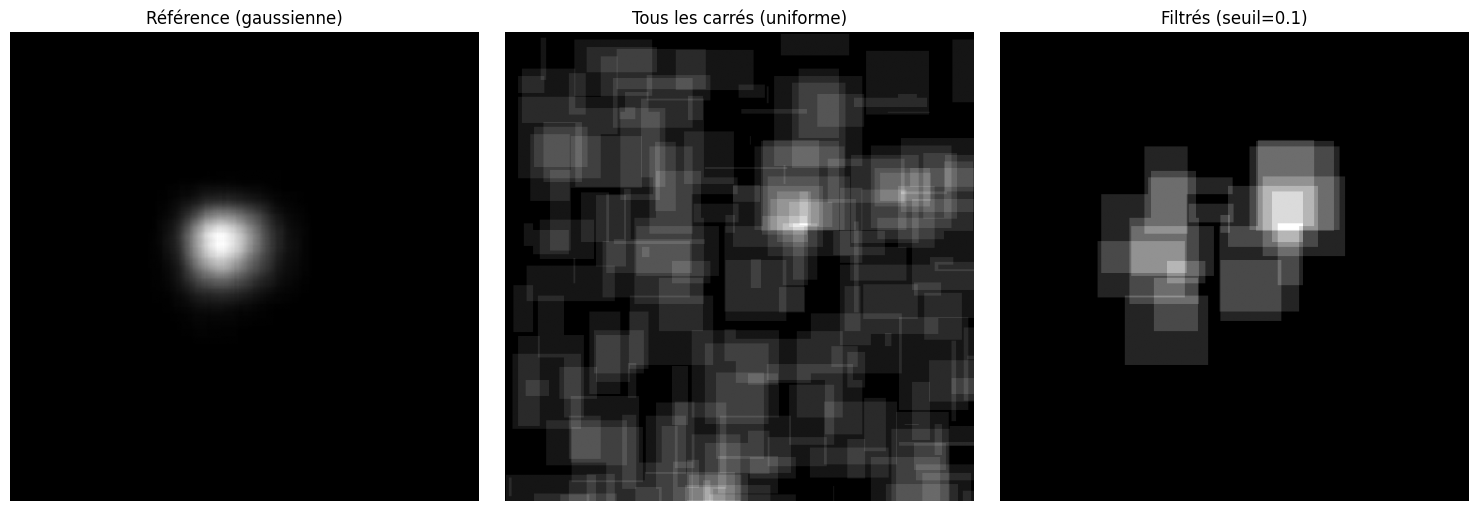

In [5]:
# Parcourir chaque carré uniforme et évaluer son chevauchement
np.random.seed(1066)
arr_filtered = np.zeros(shape)

# Régénérer les carrés uniformes
center = np.random.random(400).reshape((200, 2)) * arr.shape[0]
size = np.random.random(400).reshape((200, 2)) * arr.shape[0] // 5

# Seuil de sélection : somme des trois métriques
threshold = 0.1

print("Chevauchement pour chaque carré :")
print("Index | Dice  | W-Dice | Corr  | Somme | Sélectionné")
print("-" * 55)

for i in range(200):
    curr = generate_square(shape, center[i], size[i])
    
    # Calculer les trois métriques
    dice, w_dice = compute_dice_voxel(arr_smooth, curr)
    corr = compute_correlation(arr_smooth, curr)
    
    # Somme des trois métriques normalisées
    score = dice + w_dice + corr
    
    # Afficher seulement les premiers 10 et les sélectionnés
    if i < 10 or score > threshold:
        selected = "OUI" if score > threshold else "NON"
        print(f"{i:4d}  | {dice:.3f} | {w_dice:.3f}  | {corr:.3f} | {score:.3f} | {selected}")
    
    # Ajouter le carré à l'image filtrée si le score dépasse le seuil
    if score > threshold:
        arr_filtered += curr

# Afficher les résultats
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(arr_smooth, cmap='gray')
axes[0].set_title("Référence (gaussienne)")
axes[0].axis('off')

axes[1].imshow(arr, cmap='gray')
axes[1].set_title("Tous les carrés (uniforme)")
axes[1].axis('off')

axes[2].imshow(arr_filtered, cmap='gray')
axes[2].set_title(f"Filtrés (seuil={threshold})")
axes[2].axis('off')

fig.tight_layout()
plt.show()

---

## Sélection par distance au barycentre

Alternativement, utiliser la **distance euclidienne** entre le barycentre de chaque carré et le barycentre de la référence.

Barycentre de la référence (gaussienne) : (227.8, 229.2)
Carré 0: distance = 104.4 px, sélectionné = NON
Carré 1: distance = 62.8 px, sélectionné = OUI
Carré 2: distance = 225.5 px, sélectionné = NON
Carré 3: distance = 278.8 px, sélectionné = NON
Carré 4: distance = 71.1 px, sélectionné = OUI
Carré 5: distance = 155.8 px, sélectionné = NON
Carré 6: distance = 312.1 px, sélectionné = NON
Carré 7: distance = 249.9 px, sélectionné = NON
Carré 8: distance = 276.7 px, sélectionné = NON
Carré 9: distance = 104.5 px, sélectionné = NON


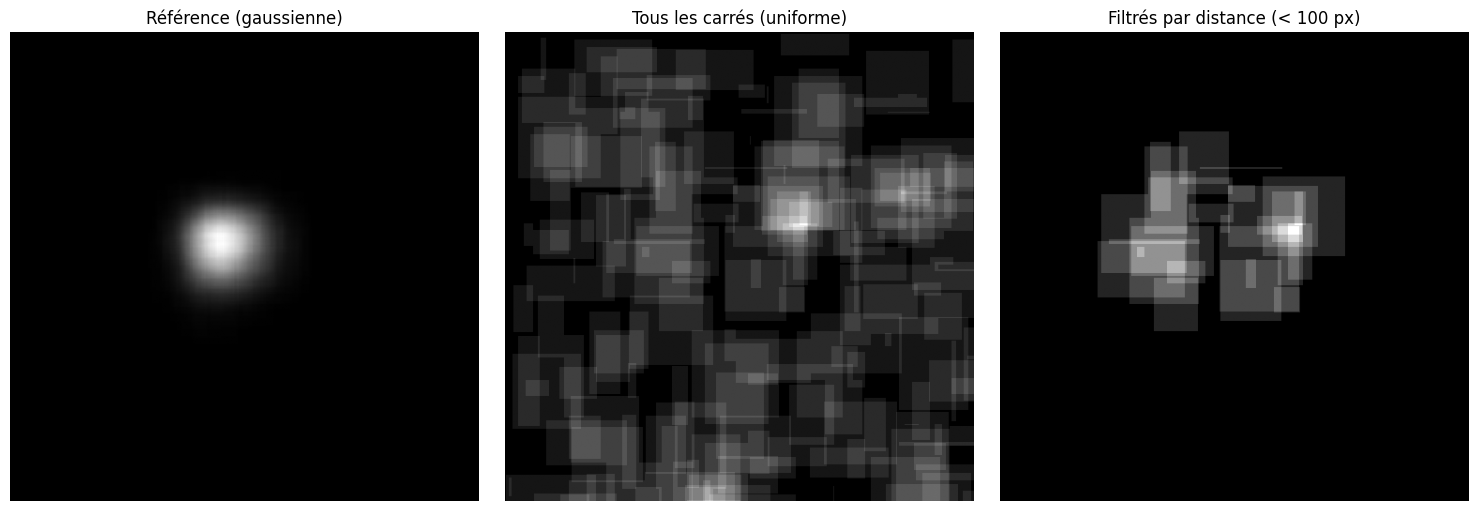

In [6]:
# Calculer le barycentre pondéré de la référence
np.random.seed(1066)
arr_by_distance = np.zeros(shape)

# Obtenir les positions pondérées par intensité dans arr_smooth
pos_smooth = np.where(arr_smooth)
val_smooth = arr_smooth[pos_smooth]
center_smooth = np.average(pos_smooth, axis=1, weights=val_smooth)

print(f"Barycentre de la référence (gaussienne) : ({center_smooth[0]:.1f}, {center_smooth[1]:.1f})")

# Régénérer et traiter les carrés uniformes
center = np.random.random(400).reshape((200, 2)) * arr.shape[0]
size = np.random.random(400).reshape((200, 2)) * arr.shape[0] // 5

distance_threshold = 100  # Distance maximale en pixels

for i in range(200):
    curr = generate_square(shape, center[i], size[i])
    
    # Calculer le barycentre de ce carré
    pos = np.where(curr)
    if len(pos[0]) > 1:
        pos_center = np.average(pos, axis=1)
        
        # Distance euclidienne au barycentre de référence
        distance = np.linalg.norm(pos_center - center_smooth)
        
        # Afficher seulement les premiers 10
        if i < 10:
            selected = "OUI" if distance < distance_threshold else "NON"
            print(f"Carré {i}: distance = {distance:.1f} px, sélectionné = {selected}")
        
        # Ajouter à l'image si distance assez petite
        if distance < distance_threshold:
            arr_by_distance += curr

# Afficher les résultats
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(arr_smooth, cmap='gray')
axes[0].set_title("Référence (gaussienne)")
axes[0].axis('off')

axes[1].imshow(arr, cmap='gray')
axes[1].set_title("Tous les carrés (uniforme)")
axes[1].axis('off')

axes[2].imshow(arr_by_distance, cmap='gray')
axes[2].set_title(f"Filtrés par distance (< {distance_threshold} px)")
axes[2].axis('off')

fig.tight_layout()
plt.show()

---

## Résumé

- **Génération synthétique** : créer des données pour valider les algorithmes
- **Métriques Dice** : évaluer le chevauchement binaire et pondéré
- **Corrélation** : mesurer la similitude statistique
- **Distance euclidienne** : sélection basée sur la localisation spatiale
- **Filtrage** : appliquer des seuils pour ne garder que les bonnes correspondances

Prochain chapitre : `j_compute_snr.ipynb`